# Importing Necessary Libraries

In [1]:
from skimage.io import imread
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

# Reading Image

In [2]:
car_image = imread('car.jpg', as_gray = True)
print(car_image)

[[0.19607843 0.16470588 0.17254902 ... 0.16862745 0.16078431 0.18823529]
 [0.16470588 0.1372549  0.14509804 ... 0.1372549  0.12941176 0.15686275]
 [0.17647059 0.14901961 0.15686275 ... 0.14509804 0.1372549  0.16470588]
 ...
 [0.23137255 0.2        0.2        ... 0.18039216 0.16470588 0.18823529]
 [0.22352941 0.19215686 0.19215686 ... 0.17254902 0.15686275 0.18039216]
 [0.26666667 0.23529412 0.23529412 ... 0.21176471 0.19607843 0.21568627]]


#### The values of the above array are ranging between 0 and 1. Multiplying them with 255 will make them range between 255.

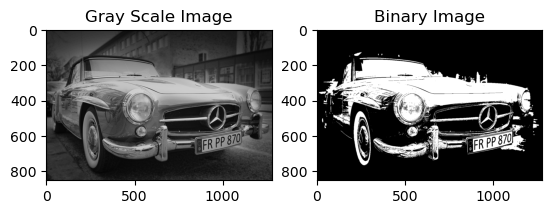

In [3]:
gray_scale_car_image = car_image * 255
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(gray_scale_car_image, cmap = 'gray')
ax1.set_title('Gray Scale Image')
threshold_val = threshold_otsu(gray_scale_car_image)

binary_car_image = gray_scale_car_image > threshold_val
ax2.imshow(binary_car_image, cmap = 'gray')
ax2.set_title('Binary Image')
plt.show()

# Connected Component Analysis (CCA)
### Used to identify all the connected components

In [4]:
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches
import localization

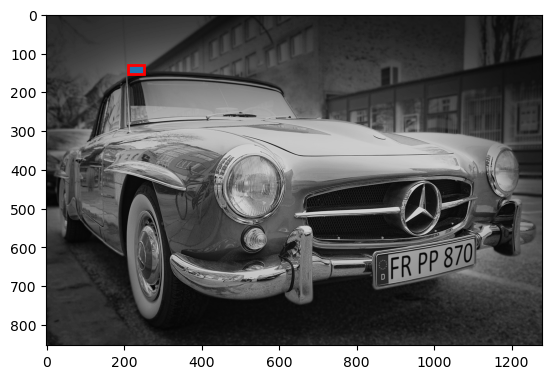

In [5]:
label_image = measure.label(binary_car_image)

figure, ax1 = plt.subplots(1)
ax1.imshow(gray_scale_car_image, cmap = 'gray')

for region in regionprops(label_image):
    if region.area < 50:
        continue

    y_min, x_min, y_max, x_max = region.bbox
    rectBorder = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor = 'red', linewidth = 2)
    ax1.add_patch(rectBorder)
    plt.show()

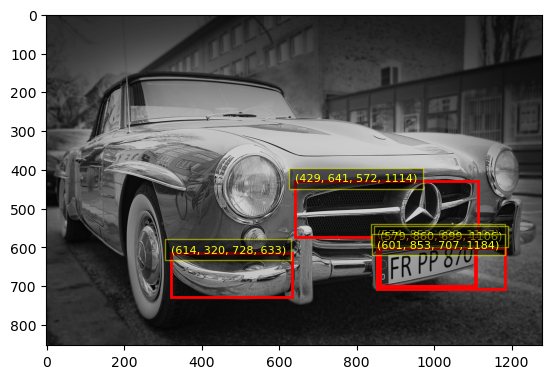

In [6]:
plate_dimensions = (0.08*label_image.shape[0], 0.2*label_image.shape[0], 0.15*label_image.shape[1], 0.4*label_image.shape[1])
min_height, max_height, min_width, max_width = plate_dimensions

plate_objects_coordinates = []
plate_like_objects = []
valid_regions = []

fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_scale_car_image, cmap="gray");

for region in regionprops(label_image):
    if region.area < 50:
        continue

    # the bounding box coordinates
    y_min, x_min, y_max, x_max = region.bbox
    region_height = y_max - y_min
    region_width = x_max - x_min
    
    # ensuring that the region identified satisfies the condition of a typical license plate
    if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
        plate_like_objects.append(binary_car_image[y_min:y_max,
                                  x_min:x_max])
        valid_regions.append((region, (y_min, x_min, y_max, x_max)))
        plate_objects_coordinates.append((y_min, x_min, y_max, x_max))
        rectBorder = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rectBorder)
        coordinates_text = f'({y_min}, {x_min}, {y_max}, {x_max})'
        ax1.text(x_min, y_min, coordinates_text, color='yellow', fontsize=8,
                 bbox=dict(facecolor='black', alpha=0.5, edgecolor='yellow'))

plt.show()

In [7]:
# print valid regions' coordinates or additional details
print("Detected license plate-like regions:")
for region, coords in valid_regions:
    print(f"Region coordinates: {coords}")

Detected license plate-like regions:
Region coordinates: (429, 641, 572, 1114)
Region coordinates: (574, 852, 699, 1107)
Region coordinates: (579, 860, 699, 1106)
Region coordinates: (601, 853, 707, 1184)
Region coordinates: (614, 320, 728, 633)


In [8]:
label_image.shape

(853, 1280)

In [9]:
plate_like_objects

[array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False,  True],
        [ True, False,  True, ...,  True, False, False],
        [ True,  True, False, ...,  True,  True, False]]),
 array([[False, False, False, ...,  True, False, False],
        [False, False, False, ...,  True,  True, False],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False,  True, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False]]),
 array([[False, False, False, ...,  True,  True, False],
        [False, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

# Character Segmentation

In [10]:
import numpy as np
from skimage.transform import resize

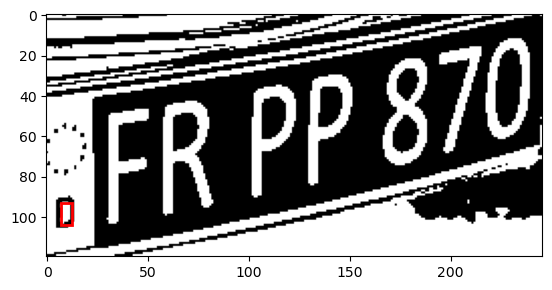

In [11]:
license_plate = np.invert(plate_like_objects[2])

labeled_plate = measure.label(license_plate)

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap = 'gray')

character_dimensions = (0.35*license_plate.shape[0], 0.60*license_plate.shape[0], 0.05*license_plate.shape[1], 0.15*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter = 0
column_list = []
for regions in regionprops(labeled_plate):
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor = 'red', linewidth = 2, fill = False)
ax1.add_patch(rect_border)

resized_char = resize(roi, (20, 20))
characters.append(resized_char)

column_list.append(x0)
plt.show()

In [12]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import joblib

In [13]:
chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
len(chars)

34

In [14]:
def read_training_data(training_directory):
    image_data = []
    target_data = []
    for char in chars:
        for each in range(10):
            img_details = imread("/Users/shubham/Documents/Rutgers University/MS in Data Science/Projects/license-plate-recognition/lpr/car.jpg", as_gray = True)
            binary_image = img_details > threshold_otsu(img_details)
            flat_bin_image = binary_image.reshape(-1)
            image_data.append(flat_bin_image)
            target_data.append(char)

    return (np.array(image_data), np.array(target_data))

In [15]:
def cross_validation(model, num_of_fold, train_data, train_label):
    accuracy_res = cross_val_score(model, train_data, train_label, cv = num_of_fold)
    print("Cross Validation Reult for ", str(num_of_fold), " -fold")
    print(accuracy_res * 100)

current_dir = "/Users/shubham/Documents/Rutgers University/MS in Data Science/Projects/license-plate-recognition/lpr"
training_dataset_dir = os.path.join(current_dir, 'train')

image_data, target_data = read_training_data(training_dataset_dir)
svc_model = SVC(kernel = 'linear', probability = True)

cross_validation(svc_model, 4, image_data, target_data)
svc_model.fit(image_data, target_data)

save_directory = os.path.join(current_dir, 'models/svc/')
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
joblib.dump(svc_model, save_directory + '/svc.pkl')

Cross Validation Reult for  4  -fold
[2.35294118 2.35294118 2.35294118 2.35294118]


['/Users/shubham/Documents/Rutgers University/MS in Data Science/Projects/license-plate-recognition/lpr/models/svc//svc.pkl']

In [23]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
from skimage.transform import resize
from skimage.measure import label

Segmentation Models: using `tf.keras` framework.


In [24]:
import segmentation

In [52]:
def segment_characters(plate_image):
    # Compute Otsu's threshold
    threshold_val = threshold_otsu(plate_image)
    
    # Convert to binary image
    binary_car_image = plate_image > threshold_val
    
    # Label connected regions
    labeled_plate = label(binary_car_image)
    
    characters = []
    column_list = []
    
    # Define character dimensions based on the image
    character_dimensions = (0.35 * plate_image.shape[0], 0.60 * plate_image.shape[0], 0.05 * plate_image.shape[1], 0.15 * plate_image.shape[1])
    min_height, max_height, min_width, max_width = character_dimensions
    
    # Segment each region that fits the dimensions of characters
    for region in regionprops(labeled_plate):
        y0, x0, y1, x1 = region.bbox
        region_height = y1 - y0
        region_width = x1 - x0

        if min_height <= region_height <= max_height and min_width <= region_width <= max_width:
            roi = binary_car_image[y0:y1, x0:x1]
            resized_char = resize(roi, (64, 64))  # Resize to match training data
            characters.append(resized_char)
            column_list.append(x0)
    
    return characters, column_list

# Load the car image and segment characters
car_image = imread('car.jpg', as_gray=True)
segmented_chars, column_list = segment_characters(car_image)


In [ ]:
import os
import joblib
import numpy as np
from skimage.transform import resize

# Set the exact training image size
TRAINING_IMAGE_SIZE = (1044, 1045)  # Initial dimensions that match the model's expected feature count

def resize_and_exact_crop(image, target_size):
    # Resize the image to the target size
    resized_image = resize(image, target_size, anti_aliasing=False)
    
    current_shape = resized_image.shape

    # Calculate the exact number of features after resizing
    feature_count = current_shape[0] * current_shape[1]

    # If feature count doesn't match, adjust by cropping/padding
    if feature_count < 1091840:
        # Pad the image if needed
        pad_height = target_size[0] + (1091840 - feature_count) // target_size[1] - target_size[0]
        pad_width = target_size[1] + (1091840 - feature_count) % target_size[1] - target_size[1]
        resized_image = np.pad(resized_image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)
    elif feature_count > 1091840:
        # Crop the image if needed
        crop_height = current_shape[0] - (feature_count - 1091840) // current_shape[1]
        crop_width = current_shape[1] - (feature_count - 1091840) % current_shape[1]
        resized_image = resized_image[:crop_height, :crop_width]

    return resized_image

# Load the trained model
current_dir = os.getcwd()
model_dir = os.path.join(current_dir, 'models/svc/svc.pkl')
model = joblib.load(model_dir)

# Assume 'characters' is the list of segmented character images
# Step 6: Flatten the characters and classify
classification_result = []
for char in characters:
    resized_char = resize_and_exact_crop(char, TRAINING_IMAGE_SIZE)  # Resize and crop/pad to match training data size
    flat_char = resized_char.reshape(1, -1)  # Flatten character image
    if flat_char.size != 1091840:
        raise ValueError(f"Resized image has {flat_char.size} features, but expected 1091840.")
    result = model.predict(flat_char)
    classification_result.append(result[0])

print("Classification Result:", classification_result)

# Step 7: Reconstruct the license plate string
plate_string = ''.join(classification_result)
column_list_copy = column_list[:]
column_list.sort()
rightplate_string = ''.join([plate_string[column_list_copy.index(col)] for col in column_list])

print("Reconstructed Plate String:", rightplate_string)

In [32]:
import imgaug
import imgaug.augmenters as iaa
from skimage.io import imread
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers, models

In [34]:
def augment_image(image):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Crop(percent=(0, 0.1)),  # random crops
        iaa.GaussianBlur(sigma=(0, 0.5)),  # blur
        iaa.LinearContrast((0.75, 1.5)),  # contrast
        iaa.Multiply((0.8, 1.2), per_channel=0.2)  # change brightness
    ])
    return seq(image=image)

# Example of applying augmentation
image = imread('car.jpg', as_gray=True)
image = (image * 255).astype(np.uint8)  # Convert to uint8
augmented_image = augment_image(image)

In [35]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['linear', 'rbf']
}

# Initialize the model
svc = SVC(probability=True)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(svc, param_grid, cv=4, verbose=2)
grid_search.fit(image_data, target_data)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_svc_model = grid_search.best_estimator_

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=11.3min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=11.1min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=11.0min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=11.0min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=13.0min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=62.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=13.3min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=14.1min
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=13.6min
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=11.4min
[CV] END ..................C=0.1, gamma=0.001, kernel=linear; total time=12.1min
[CV] END ..................C=0.1, gamma=0.001, 

In [44]:
from imgaug import augmenters as iaa

def augment_images(image_data):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # Horizontal flips
        iaa.Crop(percent=(0, 0.1)),  # Random crops
        iaa.GaussianBlur(sigma=(0, 0.5)),  # Gaussian blur
        iaa.LinearContrast((0.75, 1.5)),  # Contrast adjustment
        iaa.Multiply((0.8, 1.2), per_channel=0.2)  # Brightness adjustment
    ])
    return np.array([seq(image=image) for image in image_data])

# Augment your training data
augmented_images = augment_images(image_data)

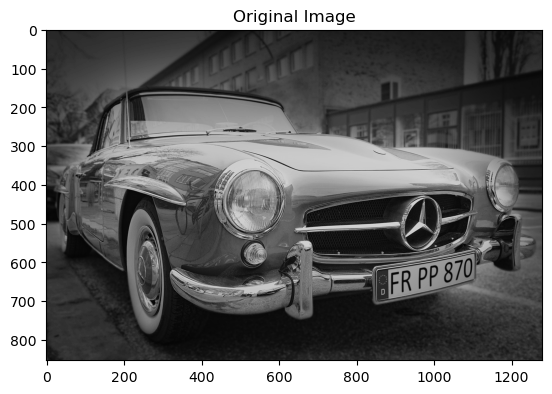

Shape of image_data: (1, 1091840)


In [55]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

# Load the single image
image_path = 'car.jpg'
car_image = imread(image_path, as_gray=True)

# Verify the image is loaded correctly
plt.imshow(car_image, cmap='gray')
plt.title("Original Image")
plt.show()

# Flatten the image for SVM training
flattened_image = car_image.flatten()
image_data = [flattened_image]  # Wrap it in a list to match the expected format

# Check the shape of the image data
print(f"Shape of image_data: {np.array(image_data).shape}")

Shape of augmented_image_data: (10, 1091840)


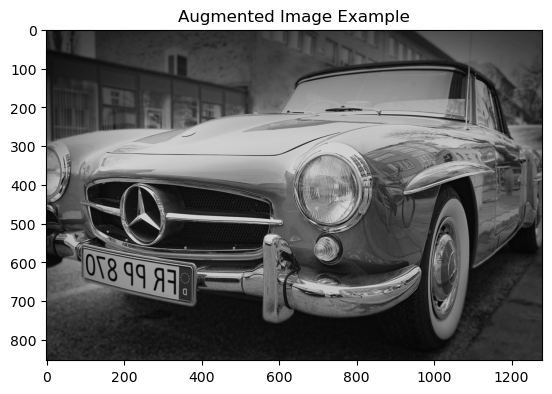

In [57]:
from imgaug import augmenters as iaa
import numpy as np

# Convert the original image to uint8 format
car_image_uint8 = (car_image * 255).astype(np.uint8)

# Function to augment a single image multiple times
def augment_image(image, num_augmentations=10):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # Horizontal flips
        iaa.Crop(percent=(0, 0.1)),  # Random crops
        iaa.GaussianBlur(sigma=(0, 0.5)),  # Gaussian blur
        iaa.LinearContrast((0.75, 1.5)),  # Contrast adjustment
        iaa.Multiply((0.8, 1.2), per_channel=0.2)  # Brightness adjustment
    ])
    augmented_images = [seq(image=image) for _ in range(num_augmentations)]
    return augmented_images

# Augment the image 10 times
augmented_images = augment_image(car_image_uint8, num_augmentations=10)

# Flatten the augmented images and prepare for training
augmented_image_data = [img.flatten() for img in augmented_images]

# Convert to a NumPy array
augmented_image_data = np.array(augmented_image_data)

# Check the shape of the augmented image data
print(f"Shape of augmented_image_data: {augmented_image_data.shape}")

# Display one of the augmented images to verify
plt.imshow(augmented_images[0], cmap='gray')
plt.title("Augmented Image Example")
plt.show()

In [59]:
from sklearn.svm import OneClassSVM
import joblib
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

# Load the single image and convert it to uint8
image_path = 'car.jpg'
car_image = imread(image_path, as_gray=True)
car_image_uint8 = (car_image * 255).astype(np.uint8)

# Function to augment a single image multiple times
def augment_image(image, num_augmentations=10):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),  # Horizontal flips
        iaa.Crop(percent=(0, 0.1)),  # Random crops
        iaa.GaussianBlur(sigma=(0, 0.5)),  # Gaussian blur
        iaa.LinearContrast((0.75, 1.5)),  # Contrast adjustment
        iaa.Multiply((0.8, 1.2), per_channel=0.2)  # Brightness adjustment
    ])
    augmented_images = [seq(image=image) for _ in range(num_augmentations)]
    return augmented_images

# Augment the image 10 times
augmented_images = augment_image(car_image_uint8, num_augmentations=10)

# Flatten the augmented images and prepare for training
augmented_image_data = [img.flatten() for img in augmented_images]

# Convert to a NumPy array
augmented_image_data = np.array(augmented_image_data)

# Initialize the One-Class SVM model
oc_svm_model = OneClassSVM(gamma='auto', nu=0.1).fit(augmented_image_data)

# Save the trained model
model_save_path = 'one_class_svm_plate_recognition_model.pkl'
joblib.dump(oc_svm_model, model_save_path)

print(f"One-Class SVM model training complete. Model saved to {model_save_path}.")

# Optionally, you can test the model on the same data or new data
# Example of testing on one of the augmented images
test_image = augmented_image_data[0]
prediction = oc_svm_model.predict([test_image])

# Check prediction (1 for inliers, -1 for outliers)
print(f"Prediction for the test image: {'Inlier (plate detected)' if prediction[0] == 1 else 'Outlier (no plate detected)'}")

One-Class SVM model training complete. Model saved to one_class_svm_plate_recognition_model.pkl.
Prediction for the test image: Inlier (plate detected)


In [60]:
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.transform import resize
import matplotlib.patches as patches

def segment_characters(plate_image):
    # Convert the image to binary using Otsu's thresholding
    threshold_val = threshold_otsu(plate_image)
    binary_plate_image = plate_image > threshold_val
    
    # Label connected regions in the binary image
    labeled_plate = label(binary_plate_image)
    
    fig, ax1 = plt.subplots(1)
    ax1.imshow(plate_image, cmap='gray')

    characters = []
    column_list = []

    # Define character dimensions based on the plate image
    character_dimensions = (0.35 * plate_image.shape[0], 0.60 * plate_image.shape[0],
                            0.05 * plate_image.shape[1], 0.15 * plate_image.shape[1])
    min_height, max_height, min_width, max_width = character_dimensions
    
    # Segment each region that fits the dimensions of characters
    for region in regionprops(labeled_plate):
        y0, x0, y1, x1 = region.bbox
        region_height = y1 - y0
        region_width = x1 - x0

        if min_height <= region_height <= max_height and min_width <= region_width <= max_width:
            roi = binary_plate_image[y0:y1, x0:x1]
            resized_char = resize(roi, (20, 20))  # Resize to a fixed size
            characters.append(resized_char)
            column_list.append(x0)

            # Draw a rectangle around the detected character
            rect_border = patches.Rectangle((x0, y0), region_width, region_height,
                                            edgecolor='red', linewidth=2, fill=False)
            ax1.add_patch(rect_border)
    
    plt.show()
    return characters, column_list

In [62]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import joblib
import numpy as np

# Assume `images` is your dataset of character images, and `labels` are the corresponding labels
# For demonstration, using the digits dataset from sklearn
digits = datasets.load_digits()
images = digits.images
labels = digits.target

# Flatten the images
n_samples = len(images)
data = images.reshape((n_samples, -1))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, shuffle=False)

# Train an SVM model
svc_model = SVC(kernel='linear', probability=True)
svc_model.fit(X_train, y_train)

# Evaluate the model
accuracy = svc_model.score(X_test, y_test)
print(f"Model accuracy: {accuracy * 100:.2f}%")

# Save the trained model
model_save_path = 'character_recognition_svc_model.pkl'
joblib.dump(svc_model, model_save_path)

print(f"Character recognition model saved to {model_save_path}.")

Model accuracy: 94.44%
Character recognition model saved to character_recognition_svc_model.pkl.


In [67]:
from skimage.transform import resize

# Function to resize and flatten the segmented characters for SVM prediction
def preprocess_characters_for_svm(characters, target_size=(8, 8)):
    processed_characters = []
    for char in characters:
        # Convert boolean image to float (0.0 to 1.0)
        char_float = char.astype(float)
        resized_char = resize(char_float, target_size, anti_aliasing=True)
        flattened_char = resized_char.flatten()  # Flatten to match SVM input
        processed_characters.append(flattened_char)
    return np.array(processed_characters)

# Assuming `segmented_characters` is the list of segmented character images
# Resize and preprocess the segmented characters
processed_characters = preprocess_characters_for_svm(segmented_characters, target_size=(8, 8))

# Predict using the SVM model
recognized_plate = svc_model.predict(processed_characters)

# Print the recognized characters
print("Recognized License Plate: ", ''.join(map(str, recognized_plate)))


Recognized License Plate:  7


In [68]:
from skimage.transform import resize

# Function to resize and flatten the segmented characters for SVM prediction
def preprocess_characters_for_svm(characters, target_size=(8, 8)):
    processed_characters = []
    for char in characters:
        resized_char = resize(char, target_size, anti_aliasing=False)  # Set anti_aliasing to False
        flattened_char = resized_char.flatten()  # Flatten to match SVM input
        processed_characters.append(flattened_char)
    return np.array(processed_characters)

# Assuming `segmented_characters` is the list of segmented character images
# Resize and preprocess the segmented characters
processed_characters = preprocess_characters_for_svm(segmented_characters, target_size=(8, 8))

# Predict using the SVM model
recognized_plate = svc_model.predict(processed_characters)

# Print the recognized characters
print("Recognized License Plate: ", ''.join(map(str, recognized_plate)))


Recognized License Plate:  7


In [69]:
# Predict the characters using the trained SVM model
recognized_plate = svc_model.predict(processed_characters)

# Print the recognized characters as a license plate
recognized_license_plate = ''.join(map(str, recognized_plate))
print("Recognized License Plate: ", recognized_license_plate)

Recognized License Plate:  7


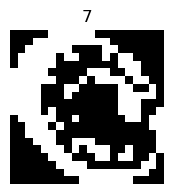

In [71]:
import matplotlib.pyplot as plt

# Display each character and its predicted label
fig, axes = plt.subplots(1, len(processed_characters), figsize=(10, 2))

# If there's only one character, axes will not be a list, so we need to handle that case
if len(processed_characters) == 1:
    axes = [axes]  # Convert to a list to handle uniformly

for i, (char_image, predicted_label) in enumerate(zip(segmented_characters, recognized_plate)):
    axes[i].imshow(char_image, cmap='gray')
    axes[i].set_title(predicted_label)
    axes[i].axis('off')

plt.show()

Recognized License Plate: 7


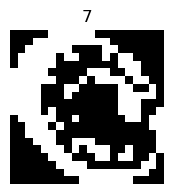

In [72]:
import matplotlib.pyplot as plt

# Predict the characters using the trained SVM model
recognized_plate = svc_model.predict(processed_characters)

# Combine the predicted characters into a single string
recognized_license_plate = ''.join(map(str, recognized_plate))

# Print the recognized license plate
print("Recognized License Plate:", recognized_license_plate)

# Optionally, display each segmented character with its predicted label
fig, axes = plt.subplots(1, len(processed_characters), figsize=(10, 2))

# If there's only one character, make sure axes is a list
if len(processed_characters) == 1:
    axes = [axes]  # Convert to a list to handle uniformly

for i, (char_image, predicted_label) in enumerate(zip(segmented_characters, recognized_plate)):
    axes[i].imshow(char_image, cmap='gray')
    axes[i].set_title(predicted_label)
    axes[i].axis('off')

plt.show()

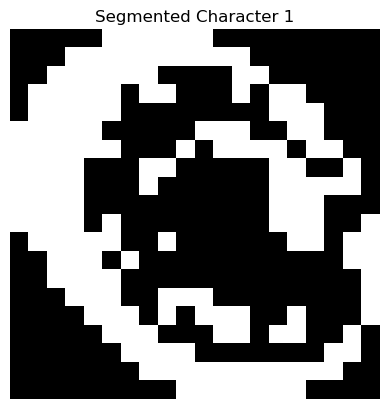

In [73]:
import matplotlib.pyplot as plt

# Display each segmented character before prediction
for i, char_image in enumerate(segmented_characters):
    plt.imshow(char_image, cmap='gray')
    plt.title(f"Segmented Character {i+1}")
    plt.axis('off')
    plt.show()


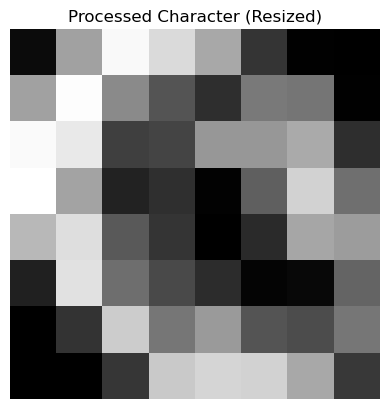

In [74]:
from skimage.transform import resize

# Function to resize and flatten the segmented characters for SVM prediction
def preprocess_characters_for_svm(characters, target_size=(8, 8)):
    processed_characters = []
    for char in characters:
        # Convert the boolean image to float and resize
        char_float = char.astype(float)
        resized_char = resize(char_float, target_size, anti_aliasing=True)
        flattened_char = resized_char.flatten()  # Flatten to match SVM input
        processed_characters.append(flattened_char)
    return np.array(processed_characters)

# Preprocess the segmented characters
processed_characters = preprocess_characters_for_svm(segmented_characters, target_size=(8, 8))

# Display the first processed character for verification
plt.imshow(processed_characters[0].reshape(8, 8), cmap='gray')
plt.title("Processed Character (Resized)")
plt.axis('off')
plt.show()


In [75]:
# Predict the characters using the trained SVM model
recognized_plate = svc_model.predict(processed_characters)

# Combine the predicted characters into a single string
recognized_license_plate = ''.join(map(str, recognized_plate))

# Print the recognized license plate
print("Recognized License Plate:", recognized_license_plate)


Recognized License Plate: 7
